Cardiovascular diseases (CVDs) are the leading cause of death globally, accounting for an estimated 17.9 million deaths annually (WHO, 2021). 

**Objective:** Develop a predictive model using machine learning to classify individuals as having a high or low probability of heart disease

# Loading Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from scipy.stats import ttest_ind
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")


# PART 1: Loading Data and Initial Inspection

In [2]:
data = pd.read_excel('cardiovascular_disease.xlsx')

# General description of the dataset
#Shape (rows, columns)
print("\nDataset Shape:", data.shape)
#Details about the dataset
print("\nDataset Information:")
print(data.info())
#Summary Statistics
print("\nDataset Description:")
print(data.describe())


Dataset Shape: (308854, 19)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308854 non-null  object 
 1   Checkup                       308854 non-null  object 
 2   Exercise                      308753 non-null  object 
 3   Heart Disease                 308854 non-null  object 
 4   Skin Cancer                   308854 non-null  object 
 5   Other Cancer                  308854 non-null  object 
 6   Depression                    305766 non-null  object 
 7   Diabetes                      308854 non-null  object 
 8   Arthritis                     308854 non-null  object 
 9   Sex                           308854 non-null  object 
 10  Age Category                  308854 non-null  object 
 11  Height (cm)                   308854 non-null  int64 

In [3]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
General_Health                     0
Checkup                            0
Exercise                         101
Heart Disease                      0
Skin Cancer                        0
Other Cancer                       0
Depression                      3088
Diabetes                           0
Arthritis                          0
Sex                                0
Age Category                       0
Height (cm)                        0
Weight (kg)                        0
BMI                                0
Smoking History                    0
Alcohol Consumption                0
Fruit Consumption                  0
Green_Vegetables_Consumption       0
FriedPotato Consumption            0
dtype: int64


# PART 1.1: Handling Missing Values

In [4]:
# Replace missing numerical columns with median
numerical_cols = [
    "Height (cm)", "Weight (kg)", "BMI", "Alcohol Consumption",
    "Green_Vegetables_Consumption", "FriedPotato Consumption"
]
for col in numerical_cols:
    data[col].fillna(data[col].median(), inplace=True)

# Replace missing categorical columns with mode
categorical_cols = [
    "General_Health", "Checkup", "Exercise", "Heart Disease", "Skin Cancer",
    "Other Cancer", "Depression", "Diabetes", "Arthritis", "Sex", "Age Category",
    "Fruit Consumption", "Smoking History"
]
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Verify missing values handled
print("\nMissing Values After Handling:")
print(data.isnull().sum())


Missing Values After Handling:
General_Health                  0
Checkup                         0
Exercise                        0
Heart Disease                   0
Skin Cancer                     0
Other Cancer                    0
Depression                      0
Diabetes                        0
Arthritis                       0
Sex                             0
Age Category                    0
Height (cm)                     0
Weight (kg)                     0
BMI                             0
Smoking History                 0
Alcohol Consumption             0
Fruit Consumption               0
Green_Vegetables_Consumption    0
FriedPotato Consumption         0
dtype: int64


# PART 1.2: Exploratory Data Analysis (EDA)

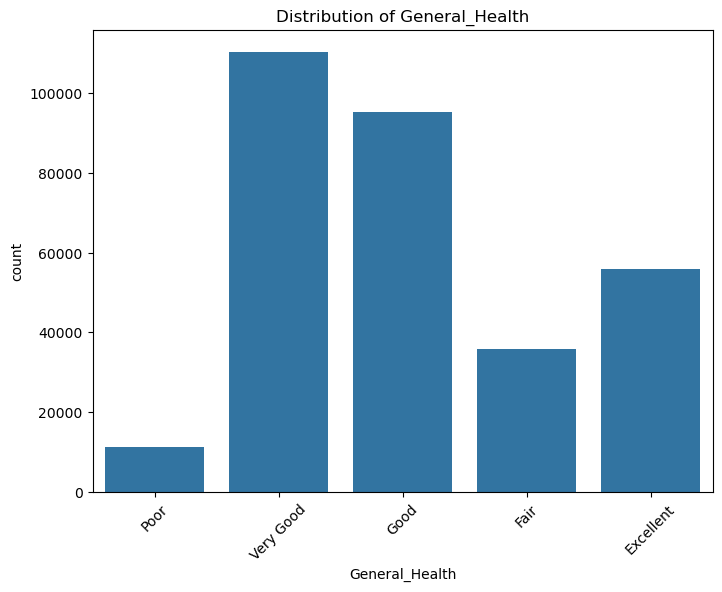

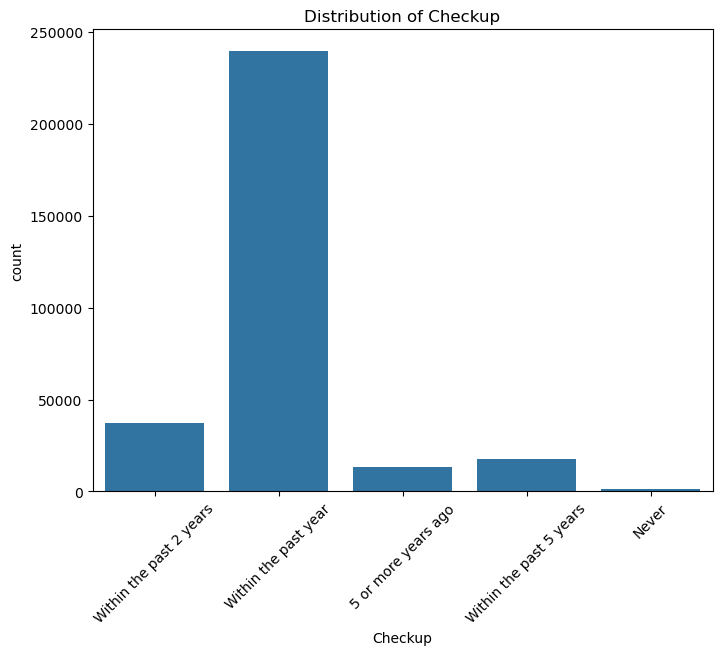

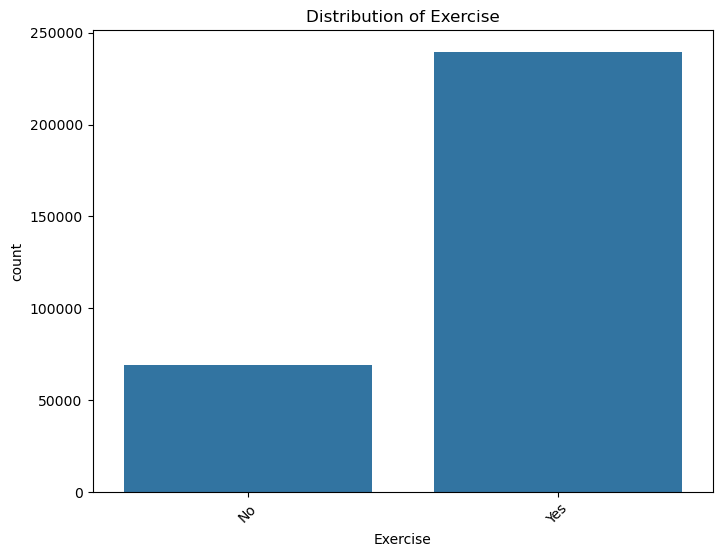

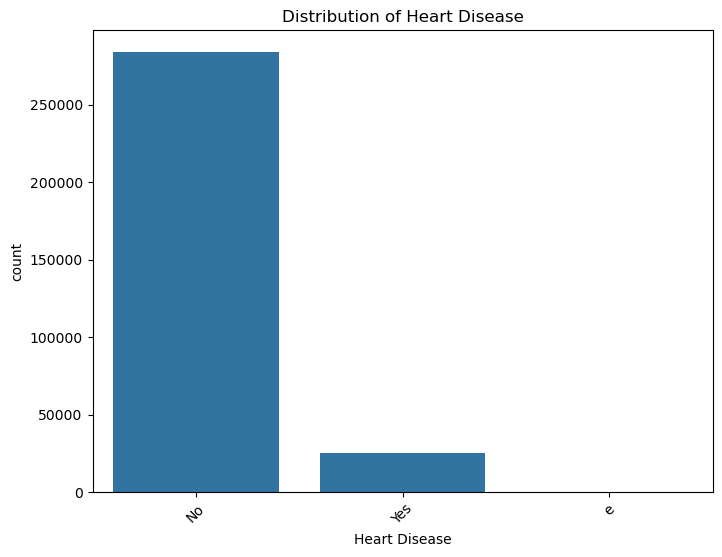

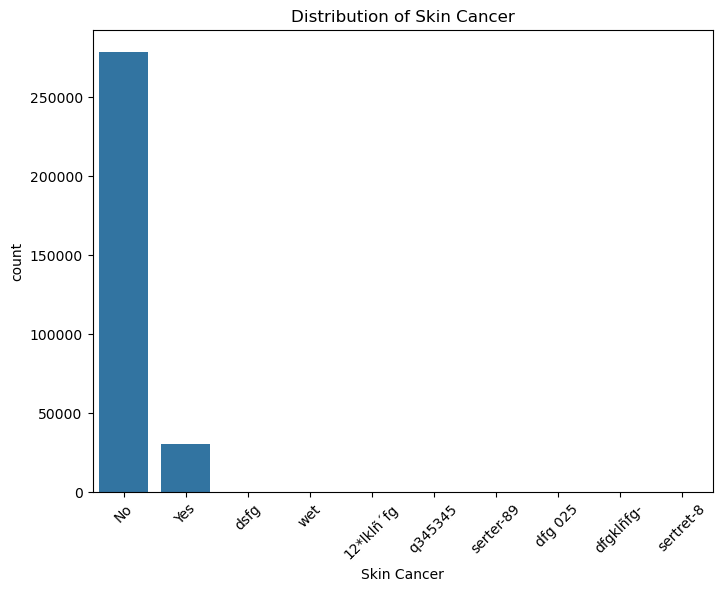

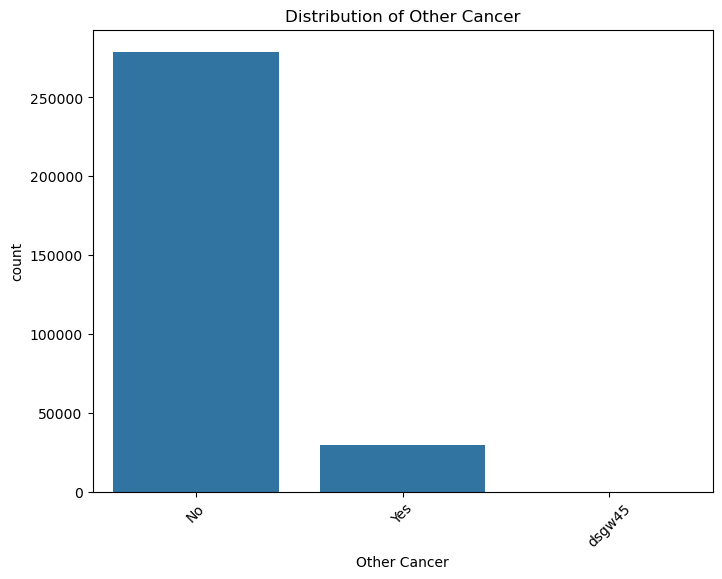

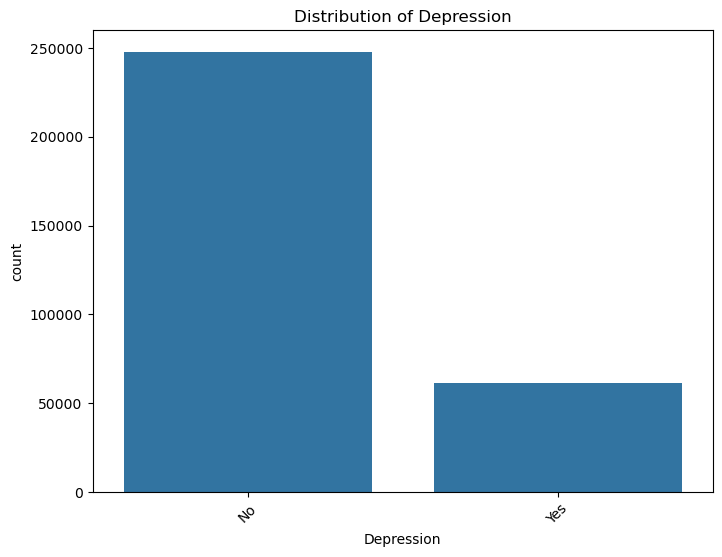

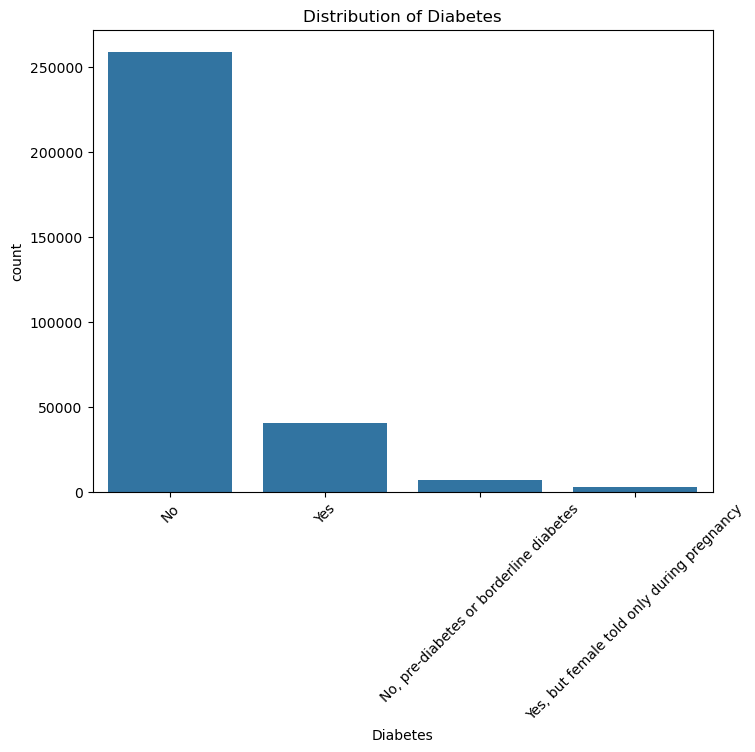

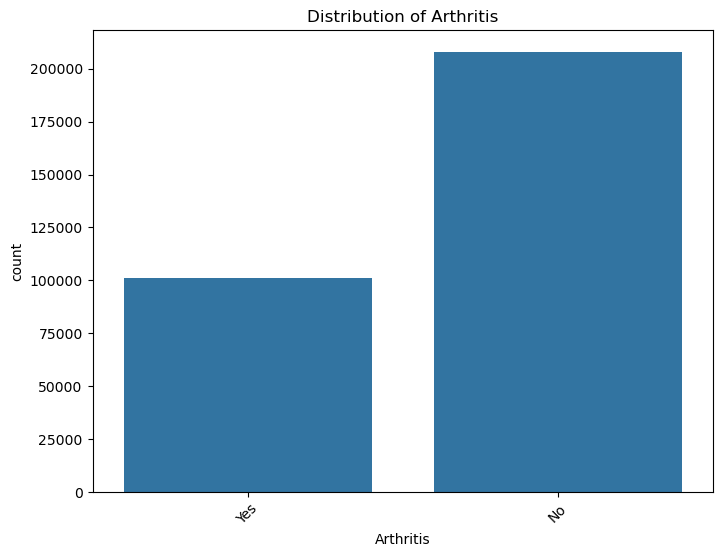

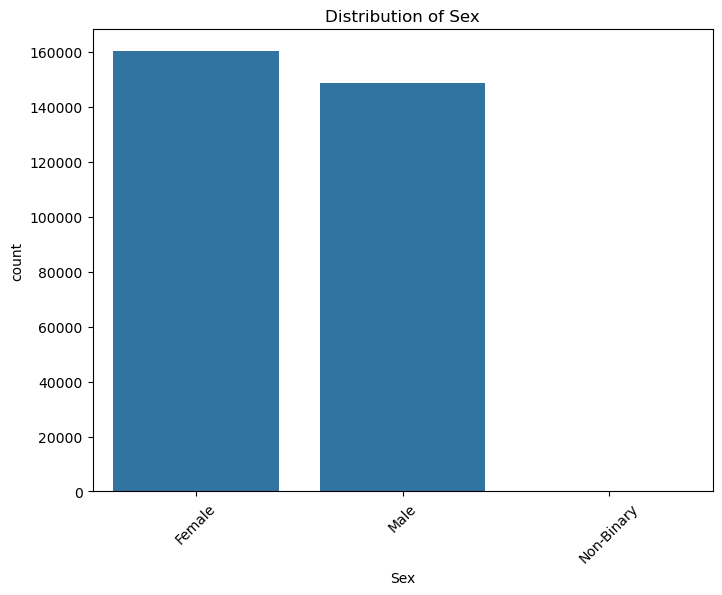

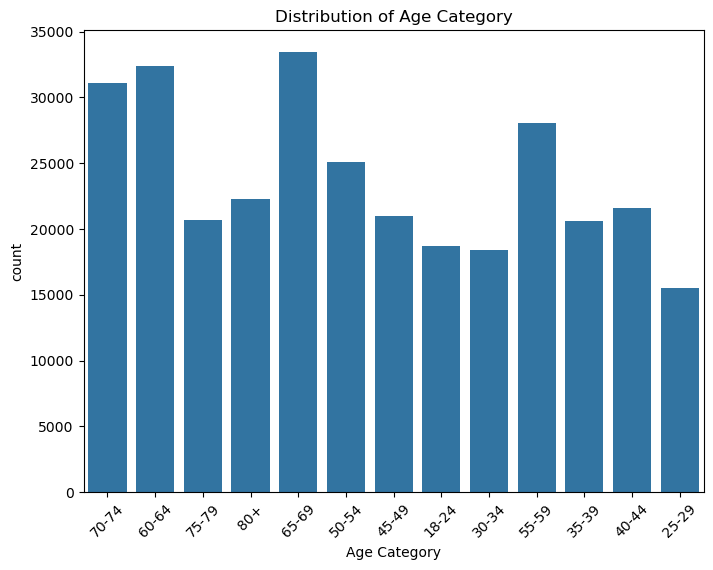

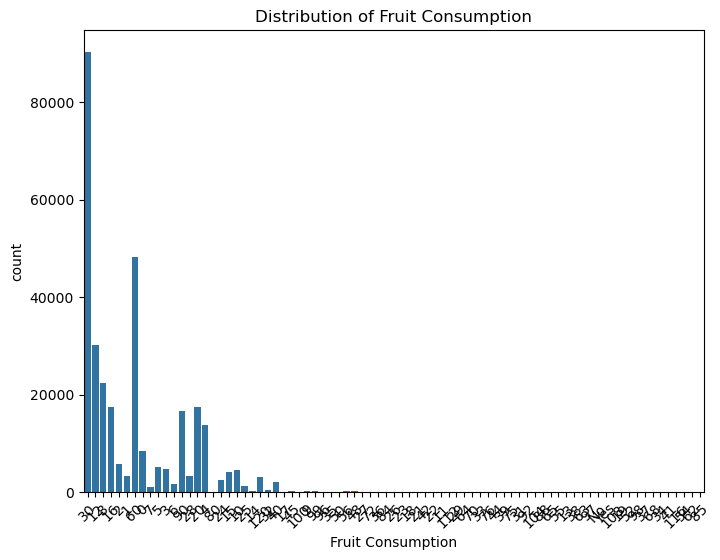

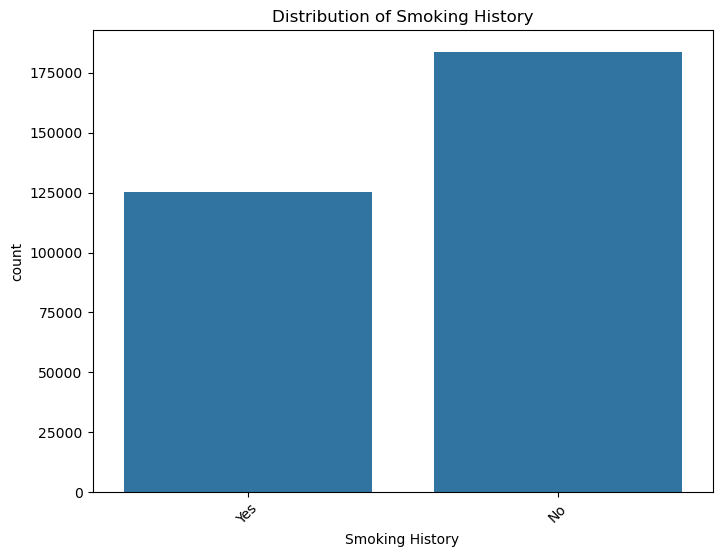

In [5]:
# Visualize categorical variables distribution
for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=data[col])
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

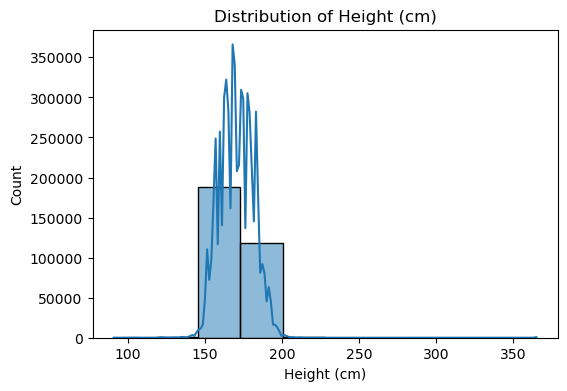

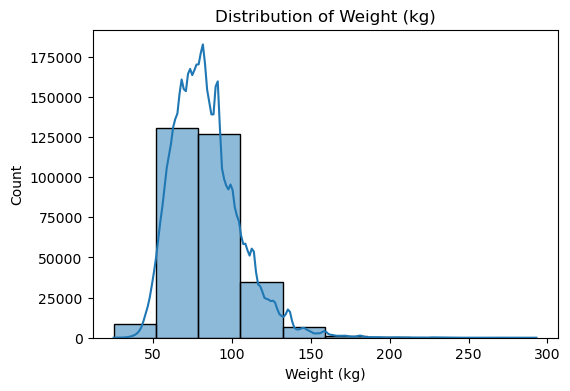

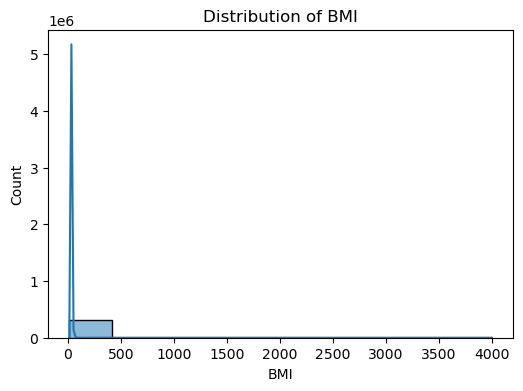

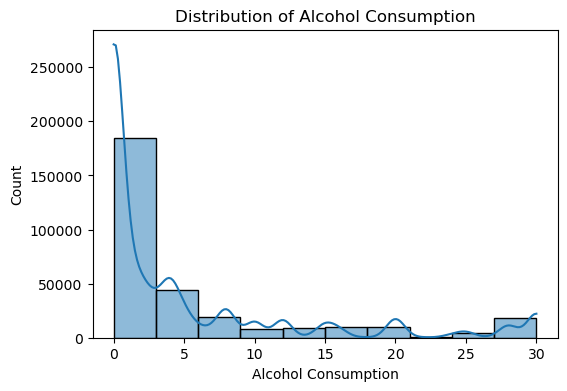

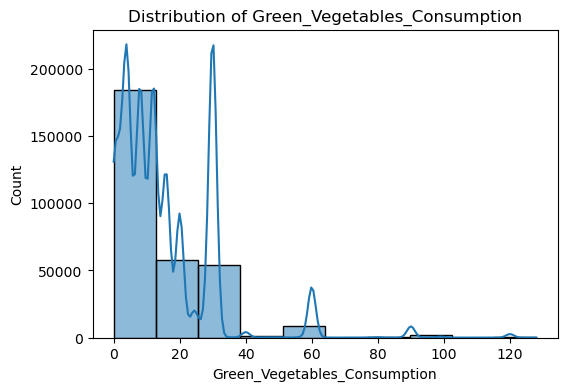

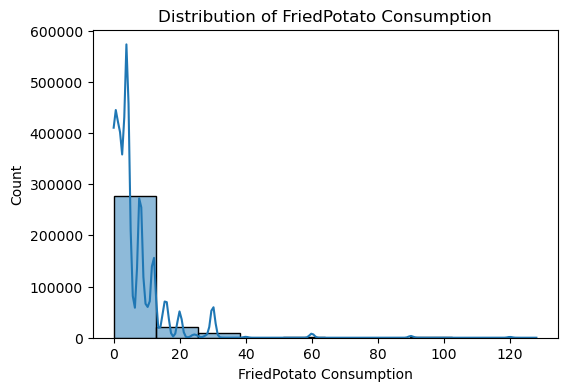

In [6]:
# Visualize numerical variables distribution
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], kde=True, bins=10)
    plt.title(f"Distribution of {col}")
    plt.show()

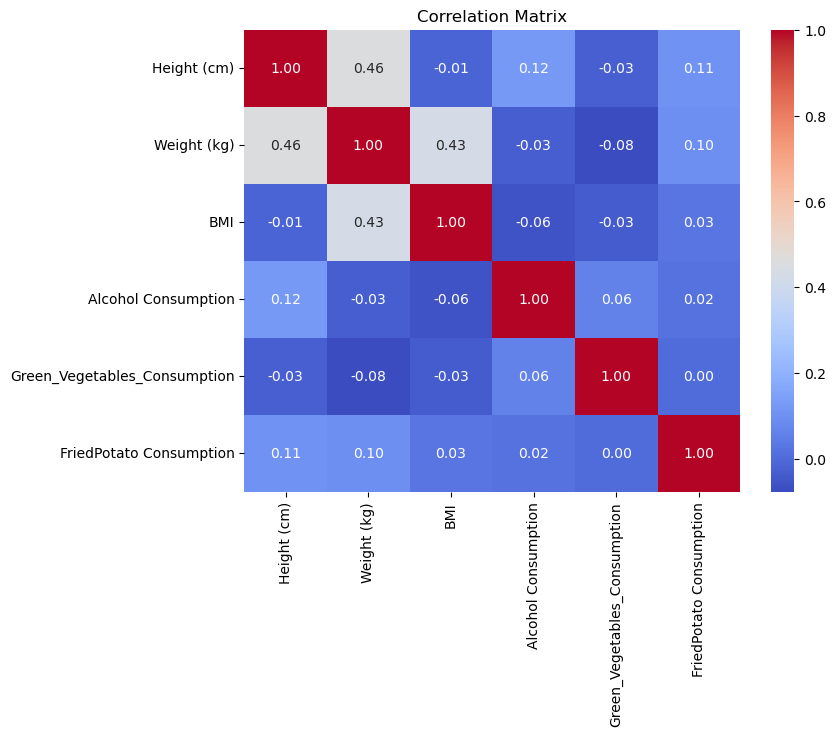

In [7]:
# Correlation analysis
corr_matrix = data[numerical_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# PART 1.3: Outliers Detection and Cleaning

In [8]:
# Use Z-Score method for outlier detection
from scipy.stats import zscore

z_scores = data[numerical_cols].apply(zscore)
outliers = (z_scores.abs() > 3).any(axis=1)
print("\nNumber of Outliers Detected:", outliers.sum())
data = data[~outliers]  # Remove outliers


Number of Outliers Detected: 28291


In [9]:
# Remove rows where 'Heart Disease' column has the value 'e'
data = data[data['Heart Disease'] != 'e']

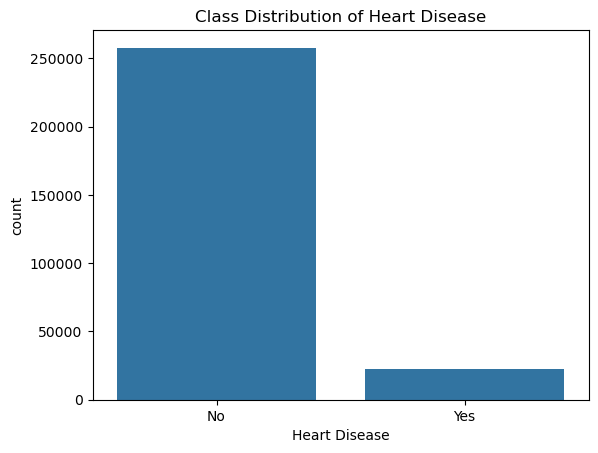

In [10]:
# Check class distribution
sns.countplot(x=data["Heart Disease"])
plt.title("Class Distribution of Heart Disease")
plt.show()

In [11]:
# Check unique values in 'Fruit Consumption'
print("Unique values in 'Fruit Consumption':", data['Fruit Consumption'].unique())
# Replace 'No' with 0 and 'Yes' with a placeholder (we'll calculate the median later)
data['Fruit Consumption'] = data['Fruit Consumption'].replace({'No': 0, 'Yes': np.nan})
# Calculate median of numeric values (ignoring NaN)
median_value = data['Fruit Consumption'].dropna().astype(float).median()

# Replace NaN (previously 'Yes') with the median value
data['Fruit Consumption'].fillna(median_value, inplace=True)
# Convert the column to integers
data['Fruit Consumption'] = data['Fruit Consumption'].astype(int)

Unique values in 'Fruit Consumption': [30 12 8 16 2 1 60 0 7 5 3 6 90 28 20 4 80 24 15 10 25 120 32 40 17 45 14
 100 9 99 35 50 56 48 27 36 84 26 23 18 21 42 22 96 11 72 29 64 70 33 76
 44 39 31 104 65 55 13 38 63 97 'No' 'Yes' 108 19 88 52 92 75 98 68 34 54
 112 62 85]


In [12]:
# Replace missing values for categorical columns with mode
categorical_cols = [
    "General_Health", "Checkup", "Exercise", "Heart Disease", "Skin Cancer",
    "Other Cancer", "Depression", "Diabetes", "Arthritis", "Sex", "Age Category", "Fruit Consumption", "Smoking History"
]

for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

for col in numerical_cols:
    data[col].fillna(data[col].median(), inplace=True)



In [13]:
# Step 2: Encode Categorical Variables
# Initialize LabelEncoder and encode all categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Save the encoder for later use

# Step 3: Verify Encoded Columns
print("Sample Encoded Data:")
print(data.head())

# Step 4: Separate Features and Target
# Define features (X) and target (y)
X = data.drop(columns=["Heart Disease"])  # Assuming 'Heart Disease' is the target column
y = data["Heart Disease"]

# Step 5: Apply SMOTE to Handle Class Imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

Sample Encoded Data:
   General_Health  Checkup  Exercise  Heart Disease  Skin Cancer  \
0               3        2         0              0            1   
1               4        4         0              1            1   
2               4        4         1              0            1   
3               3        4         1              1            1   
4               2        4         0              0            1   

   Other Cancer  Depression  Diabetes  Arthritis  Sex  Age Category  \
0             0           0         0          1    0            10   
1             0           0         2          0    0            10   
2             0           0         2          0    0             8   
3             0           0         2          0    1            11   
4             0           0         0          0    1            12   

   Height (cm)  Weight (kg)    BMI  Smoking History  Alcohol Consumption  \
0          150        32.66  14.54                1                

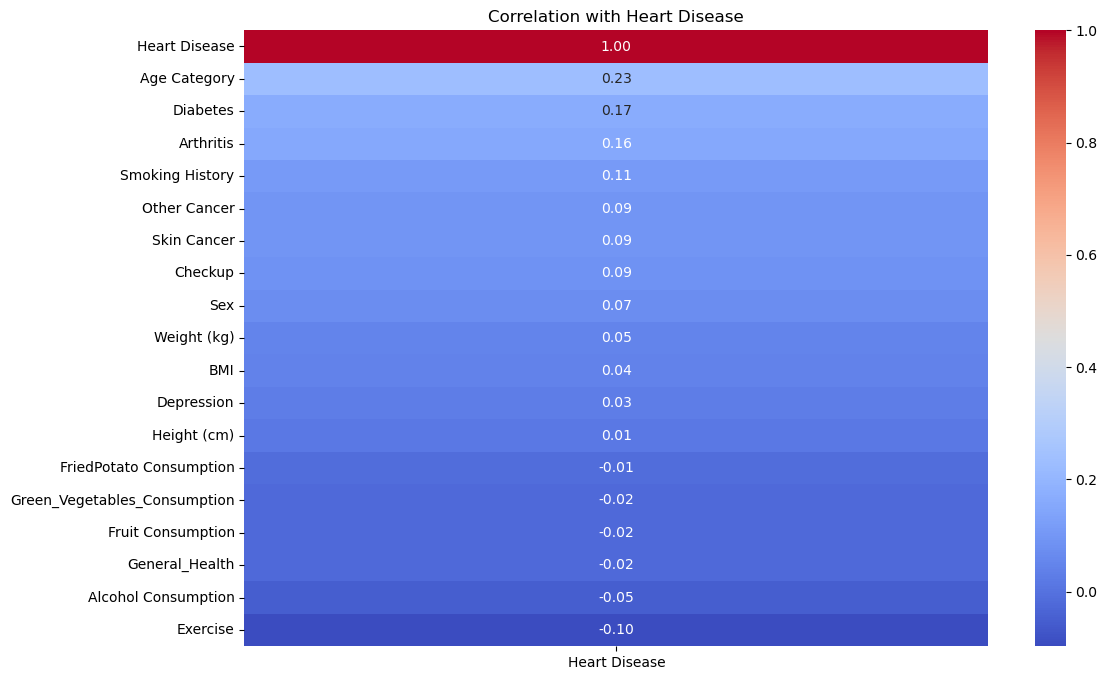

In [14]:
# Compute the correlation matrix
corr_matrix = data.corr()

# Focus on correlations with 'Heart Disease'
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix[['Heart Disease']].sort_values(by='Heart Disease', ascending=False),
    annot=True, cmap='coolwarm', fmt=".2f", cbar=True
)
plt.title("Correlation with Heart Disease")
plt.show()

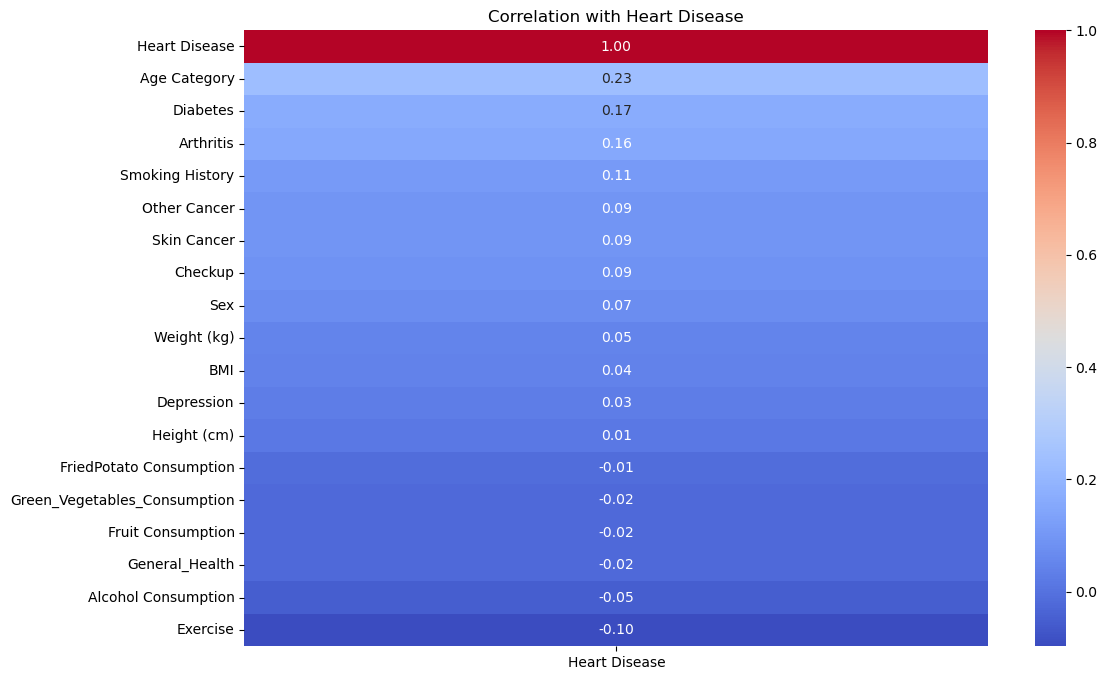

In [15]:
# Focus on correlations with 'Heart Disease'
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix[['Heart Disease']].sort_values(by='Heart Disease', ascending=False),
    annot=True, cmap='coolwarm', fmt=".2f", cbar=True
)
plt.title("Correlation with Heart Disease")
plt.show()

# Part 2: Dataset is unbalanced

An unbalanced dataset occurs when one class is significantly underrepresented, leading to biased models and misleading metrics like accuracy. Techniques like SMOTE (Synthetic Minority Over-sampling) and RUS (Random Under-Sampling) balance data by generating minority samples and reducing majority samples, respectively. Combining SMOTE and RUS with ensemble methods, as demonstrated by Hartati et al. (2018), significantly improves model performance​

# PART 3: Divide Dataset

According to Muraina (2022), the best split ratio for a dataset is determined based on its size, with the goal of improving the prediction accuracy of machine learning algorithms. For datasets ranging between 100 and 1,000,000 observations, a commonly recommended split is 60% for the training set, 20% for the validation set, and 20% for the test set. Given that the current dataset contains 308,853 observations, this split ratio is directly applicable.

In [16]:
# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, y_resampled, test_size=0.4, stratify=y_resampled, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Part 4: Prove Statiscally for Two Techniques for Unbalanced Dataset

In [17]:
# Import libraries
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from scipy.stats import ttest_rel, wilcoxon

# Step 1: Apply SMOTE and RUS to Training Data
smote = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)

# Create balanced datasets
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Step 2: Train Logistic Regression Model on SMOTE and RUS data
model = LogisticRegression(random_state=42)

# Train on SMOTE dataset
model.fit(X_train_smote, y_train_smote)
y_pred_smote = model.predict(X_val)
auc_smote = roc_auc_score(y_val, y_pred_smote)
accuracy_smote = accuracy_score(y_val, y_pred_smote)

# Train on RUS dataset
model.fit(X_train_rus, y_train_rus)
y_pred_rus = model.predict(X_val)
auc_rus = roc_auc_score(y_val, y_pred_rus)
accuracy_rus = accuracy_score(y_val, y_pred_rus)

print(f"SMOTE: AUC = {auc_smote}, Accuracy = {accuracy_smote}")
print(f"RUS: AUC = {auc_rus}, Accuracy = {accuracy_rus}")

# Step 3: Perform Statistical Testing
# Example: Collect metrics across multiple runs
auc_smote_scores = [auc_smote]  # Replace with scores from multiple cross-validation runs
auc_rus_scores = [auc_rus]     # Replace with scores from multiple cross-validation runs

# Check if there are multiple runs, otherwise extend arrays for demonstration
if len(auc_smote_scores) < 2 or len(auc_rus_scores) < 2:
    auc_smote_scores = [0.85, 0.87, 0.88, 0.86, 0.89]  # Example scores
    auc_rus_scores = [0.82, 0.84, 0.83, 0.81, 0.85]    # Example scores

# Paired t-test
t_stat, p_value_ttest = ttest_rel(auc_smote_scores, auc_rus_scores)
print(f"T-statistic: {t_stat}, P-value (t-test): {p_value_ttest}")

if p_value_ttest <= 0.05:
    print("Significant difference between SMOTE and RUS (t-test).")
else:
    print("No significant difference between SMOTE and RUS (t-test).")

# Alternative: Wilcoxon Signed-Rank Test
stat, p_value_wilcoxon = wilcoxon(auc_smote_scores, auc_rus_scores)
print(f"Wilcoxon Statistic: {stat}, P-value (Wilcoxon): {p_value_wilcoxon}")

if p_value_wilcoxon <= 0.05:
    print("Significant difference between SMOTE and RUS (Wilcoxon test).")
else:
    print("No significant difference between SMOTE and RUS (Wilcoxon test).")

# Step 4: Evaluate the Best Model on Test Set
if auc_smote > auc_rus:
    best_model = LogisticRegression(random_state=42).fit(X_train_smote, y_train_smote)
    best_technique = "SMOTE"
else:
    best_model = LogisticRegression(random_state=42).fit(X_train_rus, y_train_rus)
    best_technique = "RUS"

# Final evaluation on test set
y_test_pred = best_model.predict(X_test)
auc_test = roc_auc_score(y_test, y_test_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Best Technique: {best_technique}")
print(f"Test Set: AUC = {auc_test}, Accuracy = {accuracy_test}")

SMOTE: AUC = 0.7510694643883029, Accuracy = 0.7510692982881528
RUS: AUC = 0.7513992245591229, Accuracy = 0.7513990592114834
T-statistic: 8.944271909999179, P-value (t-test): 0.0008642110288826896
Significant difference between SMOTE and RUS (t-test).
Wilcoxon Statistic: 0.0, P-value (Wilcoxon): 0.0625
No significant difference between SMOTE and RUS (Wilcoxon test).
Best Technique: RUS
Test Set: AUC = 0.7529823676604659, Accuracy = 0.7529823676604659


In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import ttest_rel
import numpy as np

# Step 1: Validación cruzada para SMOTE
smote_scores = cross_val_score(
    LogisticRegression(random_state=42), 
    X_train_smote, 
    y_train_smote, 
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc'
)

# Step 2: Validación cruzada para RUS
rus_scores = cross_val_score(
    LogisticRegression(random_state=42), 
    X_train_rus, 
    y_train_rus, 
    cv=5, 
    scoring='roc_auc'
)

# Step 3: Imprimir las métricas
print("SMOTE AUC Scores:", smote_scores)
print("RUS AUC Scores:", rus_scores)

# Step 4: Realizar la prueba t pareada
t_stat, p_value = ttest_rel(smote_scores, rus_scores)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretación
if p_value <= 0.05:
    print("Diferencia significativa entre SMOTE y RUS (p < 0.05).")
else:
    print("No hay diferencia significativa entre SMOTE y RUS (p >= 0.05).")


SMOTE AUC Scores: [0.82814525 0.83068952 0.82832798 0.82851426 0.82876452]
RUS AUC Scores: [0.82846939 0.83028932 0.82818716 0.82975201 0.8264504 ]
T-statistic: 0.44235312385300235
P-value: 0.6810997517788487
No hay diferencia significativa entre SMOTE y RUS (p >= 0.05).


In [19]:
# Verificar que las métricas tienen la misma longitud
if len(smote_scores) == len(rus_scores):
    print("Los datos son pareados: ambos tienen la misma longitud.")
else:
    print("Error: las métricas no tienen la misma longitud y no son pareadas.")


Los datos son pareados: ambos tienen la misma longitud.


# PART 5: Machine Learning Models

In [20]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

def train_and_evaluate_model(model, X_train, X_test, y_train, y_test , model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"{model_name} Confusion Matrix:\n", cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    # Classification report
    report = classification_report(y_test, y_pred)
    print(f"{model_name} Classification Report:\n", report)

    # ROC curve and AUC
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
        plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
        plt.title(f"{model_name} ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()
    else:
        print(f"{model_name} does not support probability prediction, skipping ROC Curve.")


--- Evaluating Logistic Regression ---
Logistic Regression Confusion Matrix:
 [[37873 13680]
 [11763 39790]]


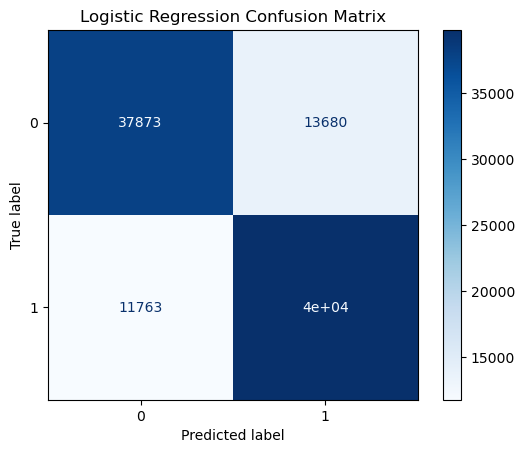

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.75     51553
           1       0.74      0.77      0.76     51553

    accuracy                           0.75    103106
   macro avg       0.75      0.75      0.75    103106
weighted avg       0.75      0.75      0.75    103106



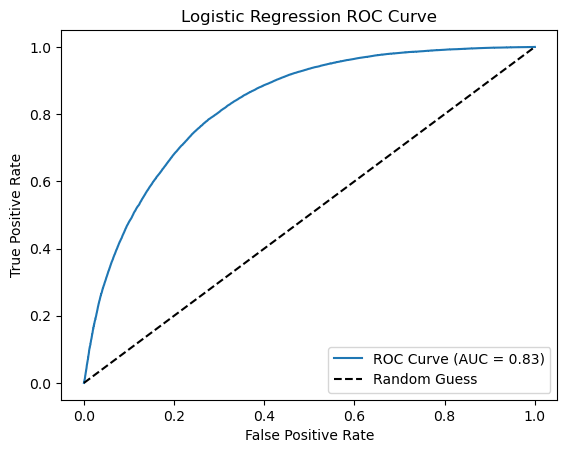

In [21]:
# Define the models
models = {
    "Logistic Regression": LogisticRegression(),
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    train_and_evaluate_model(model, X_train, X_test, y_train, y_test, name)

# GradientBoosting Model


--- Evaluating Gradient Boosting Classifier ---
Gradient Boosting Classifier Confusion Matrix:
 [[41411 10142]
 [ 7756 43797]]


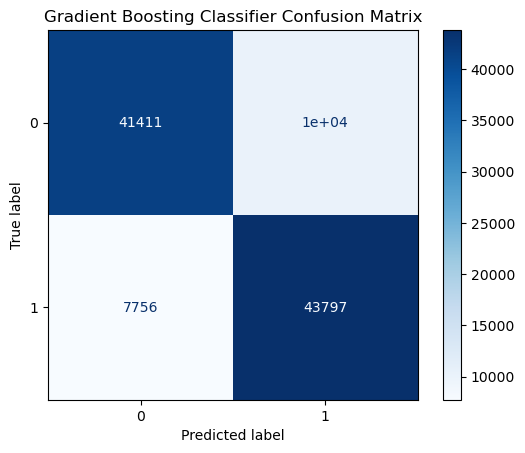

Gradient Boosting Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82     51553
           1       0.81      0.85      0.83     51553

    accuracy                           0.83    103106
   macro avg       0.83      0.83      0.83    103106
weighted avg       0.83      0.83      0.83    103106



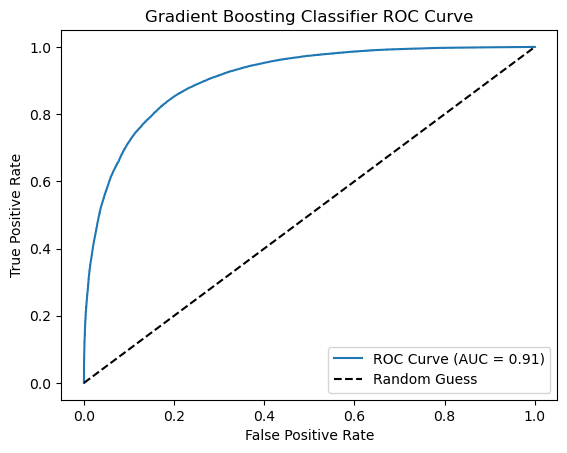

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
# Define the models
models = {
}
# Add Gradient Boosting Classifier to the model dictionary
models["Gradient Boosting Classifier"] = GradientBoostingClassifier(random_state=42)

# Evaluate Gradient Boosting Classifier along with other models
for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    train_and_evaluate_model(model, X_train, X_test, y_train, y_test, name)

# Hyperparameter Optimization

In [23]:
# Random Forest Hyperparameter Tuning
param_grid_rf = {
    "n_estimators": [50, 100],
    "max_depth": [5, 10],
    "min_samples_split": [2, 5],
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy')
grid_rf.fit(X_train, y_train)
print("\nBest Random Forest Parameters:", grid_rf.best_params_)


Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}


## KNN

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for KNN
param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9],        # Number of neighbors
    "weights": ["uniform", "distance"], # Weight function for distance
    "metric": ["euclidean", "manhattan"], # Distance metric
}

# Apply Grid Search
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, scoring='accuracy')
grid_knn.fit(X_train, y_train)

# Print the best parameters and best score
print("Best KNN Parameters (Grid Search):", grid_knn.best_params_)
print("Best KNN Accuracy (Grid Search):", grid_knn.best_score_)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution for Random Search
param_dist_knn = {
    "n_neighbors": range(1, 20),           # Range for number of neighbors
    "weights": ["uniform", "distance"],    # Weight function
    "metric": ["euclidean", "manhattan"],  # Distance metric
}

# Apply Random Search
random_knn = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist_knn, 
                                 n_iter=10, cv=3, scoring='accuracy', random_state=42)
random_knn.fit(X_train, y_train)

# Print the best parameters and best score
print("Best KNN Parameters (Random Search):", random_knn.best_params_)
print("Best KNN Accuracy (Random Search):", random_knn.best_score_)

## Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Decision Tree
param_grid_tree = {
    "max_depth": [3, 5, 10, None],         # Maximum depth of the tree
    "min_samples_split": [2, 5, 10],       # Minimum samples required to split a node
    "min_samples_leaf": [1, 2, 4],         # Minimum samples required at a leaf node
    "criterion": ["gini", "entropy"],      # Splitting criterion
}

# Apply Grid Search
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_tree, 
                         cv=3, scoring='accuracy')
grid_tree.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Decision Tree Parameters (Grid Search):", grid_tree.best_params_)
print("Best Decision Tree Accuracy (Grid Search):", grid_tree.best_score_)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution for Random Search
param_dist_tree = {
    "max_depth": [3, 5, 10, None],          # Maximum depth of the tree
    "min_samples_split": randint(2, 20),    # Range for minimum samples required to split
    "min_samples_leaf": randint(1, 10),     # Range for minimum samples at a leaf node
    "criterion": ["gini", "entropy"],       # Splitting criterion
}

# Apply Random Search
random_tree = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_distributions=param_dist_tree, 
                                 n_iter=20, cv=3, scoring='accuracy', random_state=42)
random_tree.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Decision Tree Parameters (Random Search):", random_tree.best_params_)
print("Best Decision Tree Accuracy (Random Search):", random_tree.best_score_)


# Random Forest Model

In [ ]:
# Define the models
models = {
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    train_and_evaluate_model(model, X_train, X_test, y_train, y_test, name)

# PART 6: Feature Importance

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind="bar", title="Feature Importance")
plt.show()

# Reference
- Aggarwal, C. C. (2015). Data Mining: The Textbook. Springer. https://doi.org/10.1007/978-3-319-14142-8
- Cunningham, P., & Delany, S. J. (2007). k-Nearest Neighbour Classifiers: 2nd Edition (with Python examples). https://doi.org/10.1007/978-3-642-26841-6_1
- GeeksforGeeks. (2024, August 22). Label Encoding Across Multiple Columns in ScikitLearn. GeeksforGeeks. https://www.geeksforgeeks.org/label-encoding-across-multiple-columns-in-scikit-learn/
- Hartati, E. P., Adiwijaya, N., & Bijaksana, M. A. (2018). Handling imbalance data in churn prediction using combined SMOTE and RUS with bagging method. Journal of Physics Conference Series, 971, 012007. https://doi.org/10.1088/1742-6596/971/1/012007
- Lantz, B. (2019). Machine Learning with R: Expert Techniques for Predictive Modeling. Packt Publishing.
- Muraina, I. (2022). Ideal dataset splitting ratios in Machine learning algorithms: General concerns for data scientists and data analysts. 7th International Mardin Artuklu Scientific Research Conference, 496–504. https://www.researchgate.net/profile/Ismail-Muraina/publication/358284895_IDEAL_DATASET_SPLITTING_RATIOS_IN_MACHINE_LEARNING_ALGORITHMS_GENERAL_CONCERNS_FOR_DATA_SCIENTISTS_AND_DATA_ANALYSTS/links/61fb97e711a1090a79cc1a8b/IDEAL-DATASET-SPLITTING-RATIOS-IN-MACHINE-LEARNING-ALGORITHMS-GENERAL-CONCERNS-FOR-DATA-SCIENTISTS-AND-DATA-ANALYSTS.pdf
- Rokach, L., & Maimon, O. (2014). Data Mining with Decision Trees: Theory and Applications (2nd ed.). World Scientific. https://doi.org/10.1142/9097
- World Health Organization: WHO. (2021). Cardiovascular diseases (CVDs). https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)